In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

In [2]:
import pdb
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from patch_geo_func import x_ep, y_ep
from sys import stdout
import warnings
import sobol_seq as ss
np.seterr(invalid = 'raise', under = 'ignore', over = 'ignore')

{'divide': 'raise', 'over': 'raise', 'under': 'raise', 'invalid': 'raise'}

In [3]:
from assign_attr import *
from repel_system import *

In [4]:
pos_file = 'Tmat_cortex.bin'
a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
ecc = 2.0 # must consistent with the corresponding variables in parameter.m and macro.ipynb

grid = np.array([64,104])*2
nx = grid[0]
ny = grid[1]
W = x_ep(ecc,0,k,a,b)
x = np.linspace(-W/(2*nx-4), W+W/(2*nx-4), nx)
W = W+W/(nx-2)
d = W/(nx-1)
H = d*ny
y = np.linspace(-H/2, H/2, ny)

nblock = 1
nTx = 20
nTy = 40
blockSize = nTx*nTy
n = nTx * (nTy-1)
point = np.zeros((2,n))
pos = np.zeros((1,3,nblock*blockSize))
skip = 64
i = 0
rlim = [0, ecc]
tlim = [-pi/2, pi/2]
while i < n-1:
    ntmp = n-i;
    rands = ss.i4_sobol_generate(3, ntmp, skip=skip) 
    # add noise to avoid complete overlap
    rands = rands * (1 + np.random.normal(0, 0.001, (ntmp,3)))
    pt = tlim[0] + (tlim[1]-tlim[0]) * rands[:,0]
    pr = rlim[0] + (rlim[1]-rlim[0]) * rands[:,1]
    pick = np.logical_and(np.logical_and(pt < tlim[1], pt > tlim[0]), np.logical_and(pr < rlim[1], pr > rlim[0]))
    nselect = sum(pick)
    point[0, i:i+nselect] = pt[pick]
    point[1, i:i+nselect] = pr[pick]
    i += nselect
    skip += nselect
    
for i in range(n):
    pos[0,0,i] = x_ep(point[1,i],point[0,i],k,a,b)
    pos[0,1,i] = y_ep(point[1,i],point[0,i],k,a,b)
    
xmax = x_ep(ecc,0,k,a,b)
xecc = np.linspace(0,xmax,nTx)
pos[0,0,n:nblock*blockSize] = xecc
pos[0,1,n:nblock*blockSize] = 0
    
fixed = np.arange(n,nblock*blockSize)
with open(pos_file, 'wb') as f:
    pos.tofile(f)
    
LR_Pi_file = 'Ny-2-LR_Pi.bin'
with open(LR_Pi_file, 'r') as f:
    Pi = np.reshape(np.fromfile(f, 'i4', count = nx*ny),(ny,nx))
    LR = np.reshape(np.fromfile(f, 'f8', count = nx*ny),(ny,nx)) # update to 'i4'

LR[Pi > 0] = 1
LR[Pi <= 0] = 0
OD_file = 'T_od.bin'
with open(OD_file, 'wb') as f:
    Pi.tofile(f)
    LR.tofile(f)

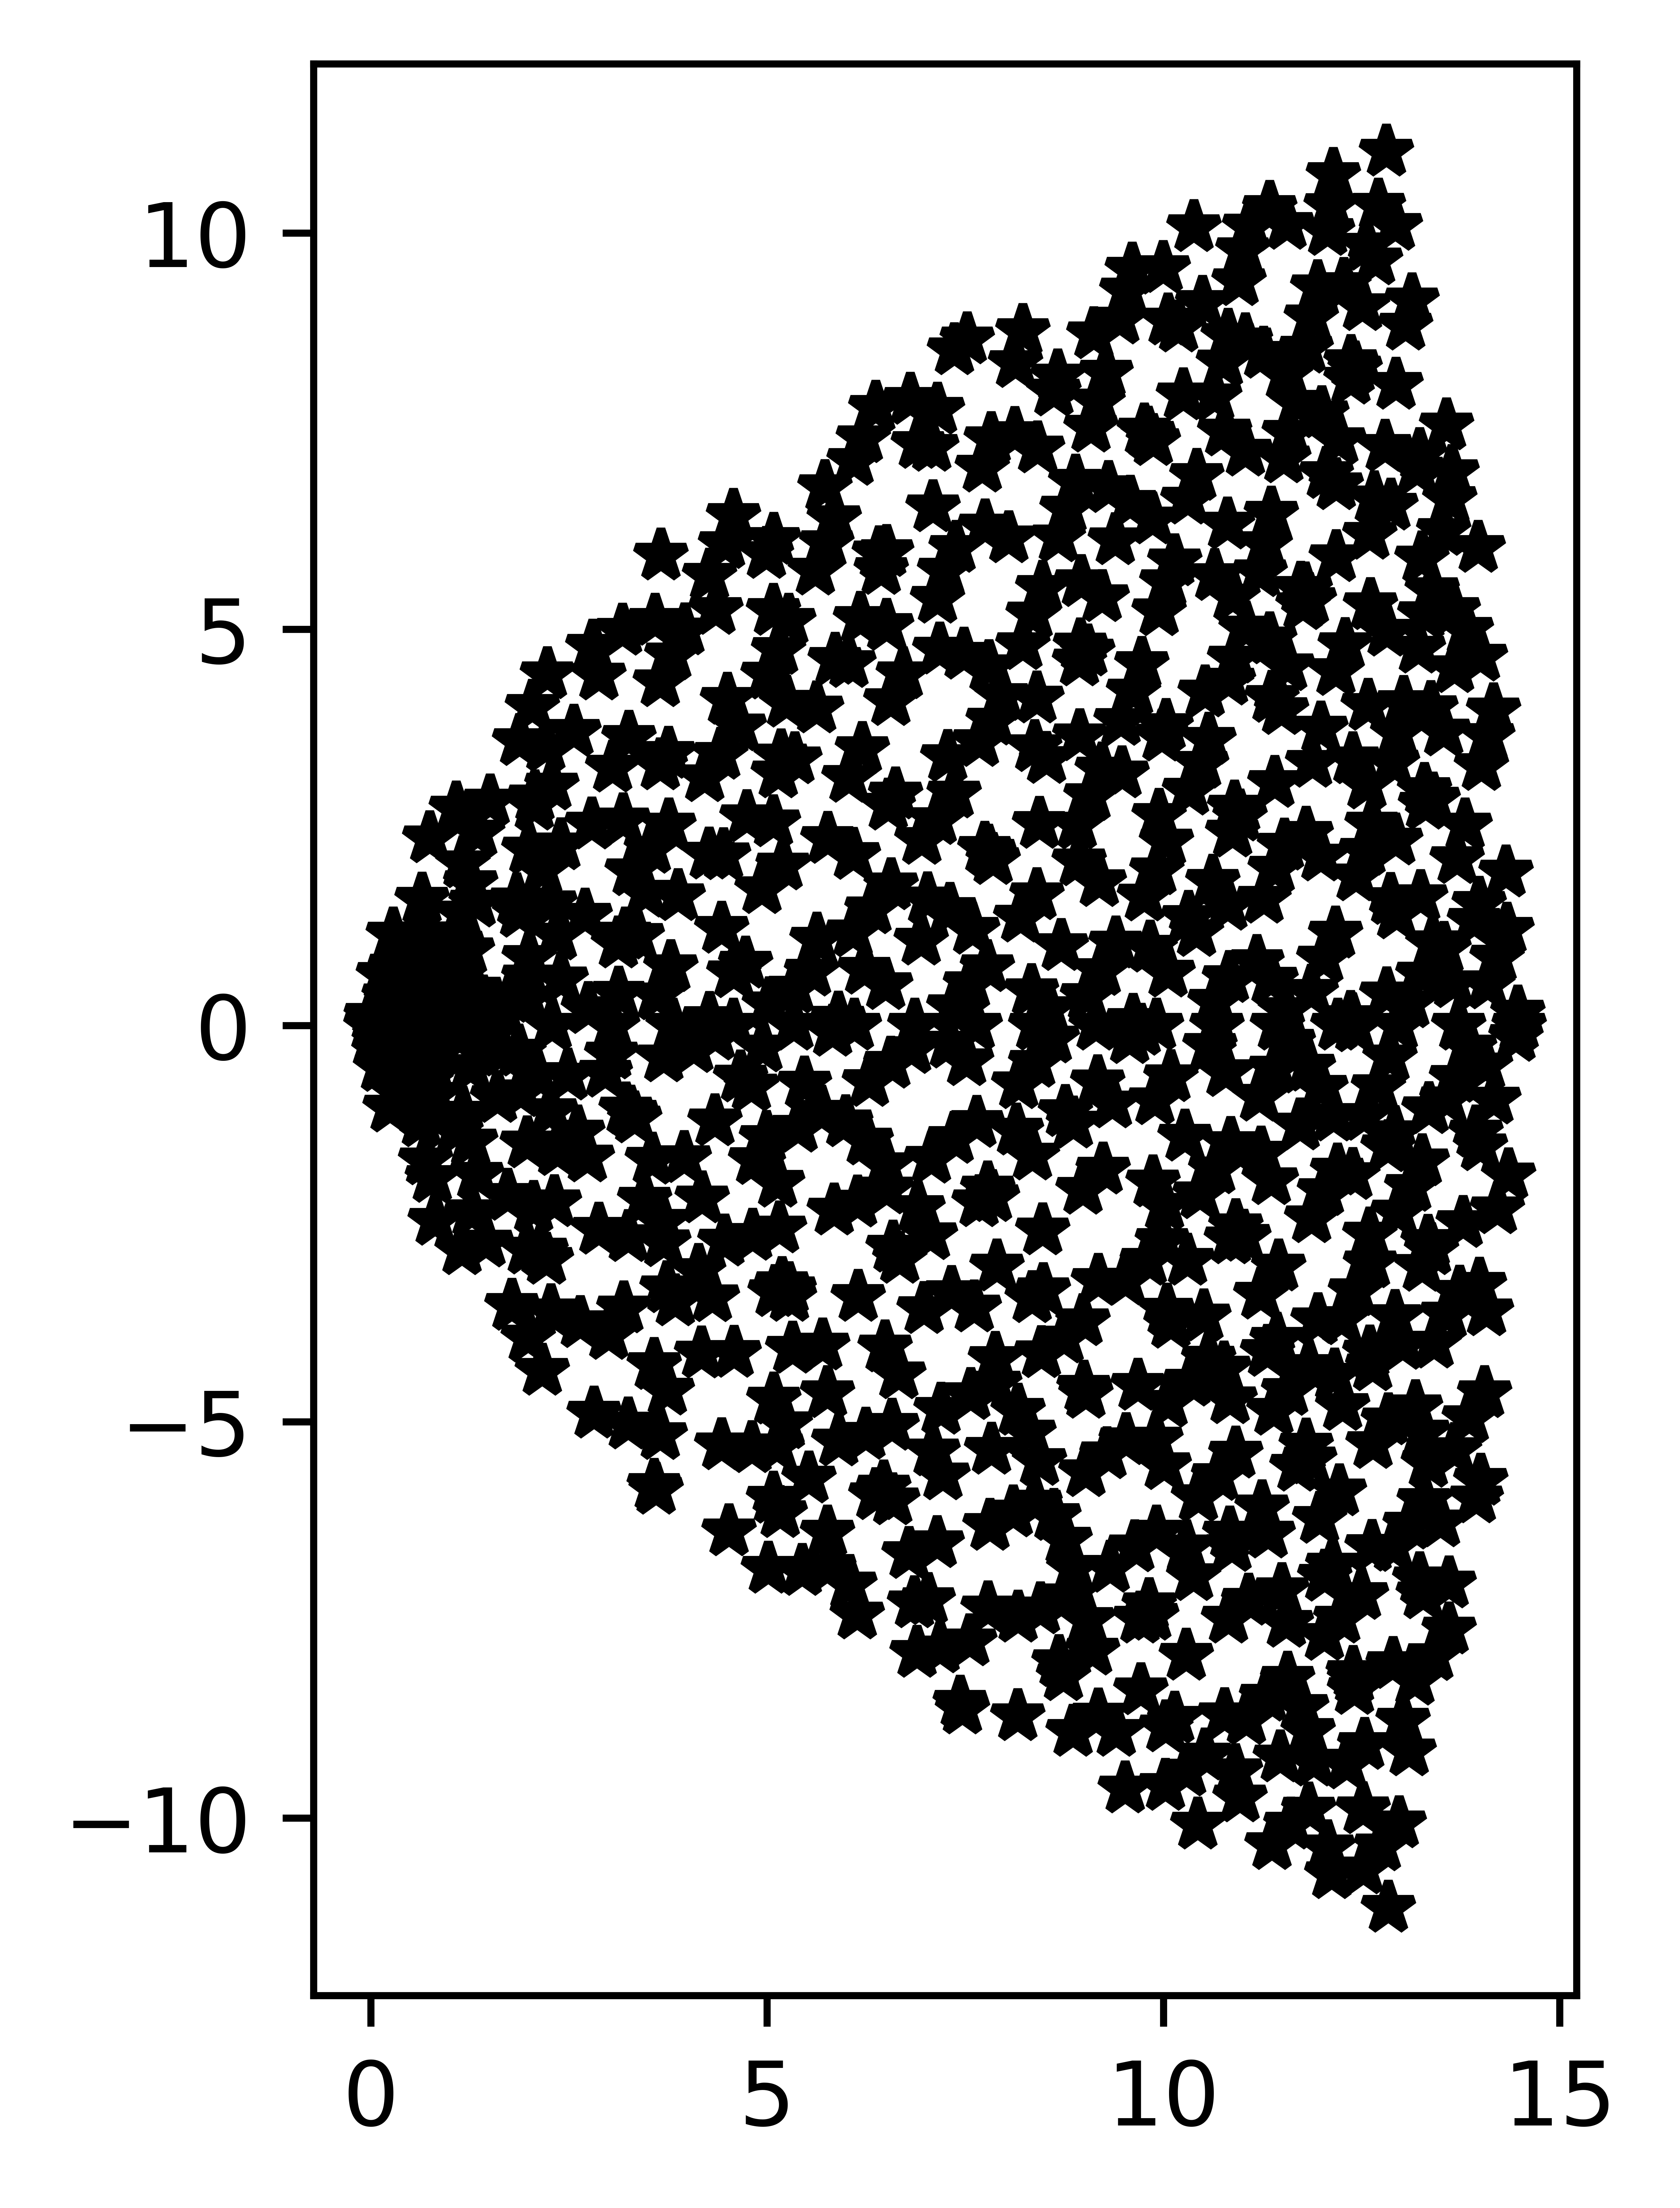

In [8]:
fig = plt.figure('t', dpi = 1000)
ax = fig.add_subplot(111)
ax.plot(pos[0,0,:], pos[0,1,:], '*k')
ax.set_aspect('equal')

In [5]:
LR_Pi_file = 'T_od.bin'

#pos_file = 'ss_pos_file.bin'
OR_file = None
vpos_file = 'Tmat_VF.bin'
uniform_pos_file = 'uniform_' + pos_file

p0 = -np.pi/2
p1 = np.pi/2

#mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, 'uniform_' + pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = True, OD_file = OD_file, VF_file = vpos_file)
#mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, 'uniform_' + pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = True)
mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = False)
#mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, pos_file, OR_file, a, b, k, ecc, p0, p1, posUniform = False, OD_file = OD_file)
if mMap.pODready:
    assert(np.sum(mMap.ODlabel>0) + np.sum(mMap.ODlabel<0) == mMap.networkSize)

211x342, ecc-polar grid houses 800 neurons
require 0.006 GB


In [6]:
min(x), max(x), min(y), max(y), min(pos[0,0,:]), max(pos[0,0,:]), min(pos[0,1,:]), max(pos[0,1,:])

(-0.0574997158394221,
 14.547428107373792,
 -11.959940894599798,
 11.959940894599798,
 0.0,
 14.48992839153437,
 -11.118837440275374,
 11.03636039523553)

In [13]:
fig = plt.figure('macroMap',dpi=1000)
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(222, projection='polar')
ax3 = fig.add_subplot(224, projection='polar')
#mMap.pODready = False
mMap.plot_map(ax1, ax2, ax3, fig.dpi, pltOD = True, pltVF = False, pltOP = False)

ax1.set_aspect('equal')
ax2.set_thetamin(p0/np.pi*180)
ax2.set_thetamax(p1/np.pi*180)
ax2.set_rmax(2.0)
ax2.set_rmin(0.0)
ax2.grid(False)
ax2.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)

ax3.set_thetamin(p0/np.pi*180)
ax3.set_thetamax(p1/np.pi*180)
ax3.set_rmax(2.0)
ax3.set_rmin(0.0)
ax3.grid(False)
ax3.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)

fig.savefig('sobol_test_low_density_uniform.png')
mMap.save(OD_file = 'ss_od_file.bin')

get the index of the nearest vertex for each neuron in its own grid
calculate neurons' cortical distance to the nearest vertex in the grid
0
adjust neuron positions near the boundary
#boundary points: 33 
assign ocular dominance preference to neuron according to their position in the cortex
retract neurons from the OD-boundary to avoid extreme repelling force later
get the index of the nearest vertex for each neuron in its own grid
calculate neurons' cortical distance to the nearest vertex in the grid


In [22]:
# spread uniformly
fig = plt.figure('pos', dpi = 600)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(121)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
ax2.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax2.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax2.set_aspect('equal')
dt0 = np.power(2.0,-np.arange(5,6)).reshape(1,1)
dt1 = np.power(2.0,-np.arange(6,7)).reshape(1,1)
dt = np.hstack((np.tile(dt0,(30,1)).flatten(), np.tile(dt1,(5,1)).flatten()))
#dt = np.tile(dt0,(15,1))
mMap.make_pos_uniformT(dt, seed = 17482321, ax1 = ax1, ax2 = ax2, fixed = fixed)
fig.savefig(pos_file+'.png', dpi = 2000)

In [25]:
mMap.vpos = mMap.assign_pos_VF(True)
with open(uniform_pos_file, 'wb') as f:
    np.array([mMap.networkSize]).tofile(f)
    mMap.pos.tofile(f)
    rx = np.array([0,ecc])
    ry = np.array([-np.pi/2, np.pi/2])
    rx.tofile(f)
    ry.tofile(f)
    mMap.vpos.tofile(f)

assgining visual field: 100.000%
